In [ ]:
import pints
import pints.toy as toy
import matplotlib.pyplot as plt
import numpy as np

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7      558485.6  558485.6   0:01.1
1     14     77997.89  77997.89   0:01.2
2     21     77997.89  503046.8   0:01.3
3     28     77997.89  498115.3   0:01.4
20    147    6231.073  38266.08   0:02.5
40    287    6231.073  7844.093   0:03.7
60    427    3975.264  4225.84    0:05.0
80    567    941.0896  1127.211   0:06.2
100   707    336.4908  408.8693   0:07.5
120   847    259.348   259.348    0:08.8
140   987    259.2348  259.2348   0:10.0
160   1127   259.2344  259.2344   0:11.3
180   1267   259.2344  259.2344   0:12.5
200   1407   259.2344  259.2344   0:13.7
220   1547   259.2344  259.2344   0:14.9
240   1687   259.2344  259.2344   0:16.1
260   1827   259.2344  259.2344   0:17.4
280   1967   259.2344  259.2344   0:18.6
300   2107   259.2344  259.2344   0:19.8
320   2247   259.2344  259.2344   0:20.9
340 

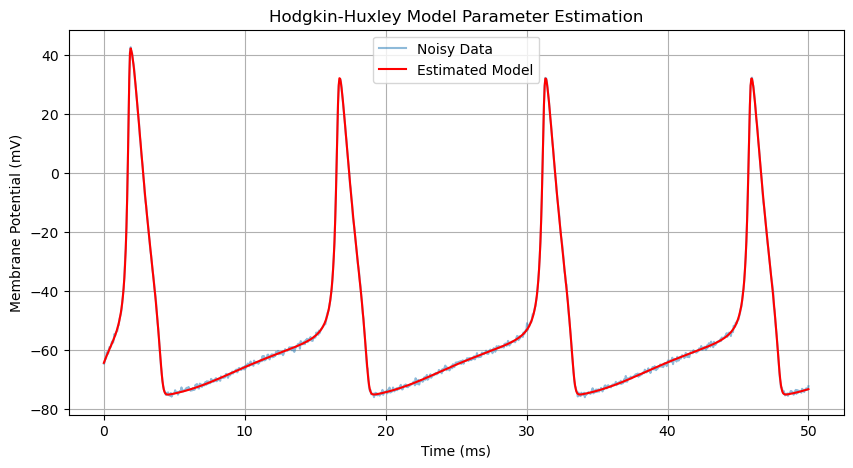

In [ ]:
class HodgkinHuxley(pints.ForwardModel):
    """
    Hodgkin-Huxley neuron model as a PINTS forward model.
    """
    def __init__(self):
        super(HodgkinHuxley, self).__init__()

        # Constants
        self.C_m = 1.0    # Membrane capacitance, in uF/cm^2
        self.g_Na = 120.0  # Maximum conductances, in mS/cm^2
        self.g_K = 36.0
        self.g_L = 0.3
        self.E_Na = 50.0   # Reversal potentials, in mV
        self.E_K = -77.0
        self.E_L = -54.387

    def n_inf(self, V):
        return 1.0 / (1.0 + np.exp(-(V + 55.0) / 10.0))

    def m_inf(self, V):
        return 1.0 / (1.0 + np.exp(-(V + 40.0) / 10.0))

    def h_inf(self, V):
        return 1.0 / (1.0 + np.exp((V + 65.0) / 6.0))

    def simulate(self, parameters, times):
        """
        Simulates the Hodgkin-Huxley model over time.
        """
        I_ext, g_Na, g_K = parameters  # External current and conductances

        # Initialize variables
        V = -65.0  # Membrane potential
        n = self.n_inf(V)
        m = self.m_inf(V)
        h = self.h_inf(V)

        dt = times[1] - times[0]
        V_trace = []

        for t in times:
            # Gating variable derivatives
            alpha_n = (0.01 * (V + 55)) / (1 - np.exp(-(V + 55) / 10))
            beta_n = 0.125 * np.exp(-(V + 65) / 80)
            dn = alpha_n * (1 - n) - beta_n * n

            alpha_m = (0.1 * (V + 40)) / (1 - np.exp(-(V + 40) / 10))
            beta_m = 4.0 * np.exp(-(V + 65) / 18)
            dm = alpha_m * (1 - m) - beta_m * m

            alpha_h = 0.07 * np.exp(-(V + 65) / 20)
            beta_h = 1 / (1 + np.exp(-(V + 35) / 10))
            dh = alpha_h * (1 - h) - beta_h * h

            # Ionic currents
            I_Na = g_Na * (m ** 3) * h * (V - self.E_Na)
            I_K = g_K * (n ** 4) * (V - self.E_K)
            I_L = self.g_L * (V - self.E_L)

            # Membrane potential derivative
            dV = (I_ext - I_Na - I_K - I_L) / self.C_m

            # Update variables
            V += dV * dt
            n += dn * dt
            m += dm * dt
            h += dh * dt

            V_trace.append(V)

        return np.array(V_trace)

    def n_parameters(self):
        return 3  # External current, g_Na, g_K as parameters

    def generate_synthetic_data(self, true_params, times, noise_std=0.5):
        """Generate synthetic voltage data with noise."""
        voltage = self.simulate(true_params, times)
        noisy_voltage = voltage + np.random.normal(0, noise_std, voltage.shape)
        return noisy_voltage

    def optimize_parameters(self, times, noisy_data, method=pints.CMAES):
        """Estimate I_ext, g_Na, and g_K using PINTS optimization."""
        problem = pints.SingleOutputProblem(self, times, noisy_data)
        error_measure = pints.SumOfSquaresError(problem)
        optimizer = pints.OptimisationController(error_measure, [10, 100, 30], method=method)
        optimizer.set_max_iterations(1000)
        estimated_params, _ = optimizer.run()
        return estimated_params

if __name__ == "__main__":
    # Instantiate the model
    model = HodgkinHuxley()

    # Time array
    time = np.linspace(0, 50, 1000)  # 0 to 50 ms

    # True parameters: I_ext, g_Na, g_K
    true_params = [10, 120, 36]

    # Generate synthetic data
    noisy_voltage = model.generate_synthetic_data(true_params, time)

    # Optimize parameters
    estimated_params = model.optimize_parameters(time, noisy_voltage)
    print(f"Estimated Parameters: I_ext={estimated_params[0]:.2f}, g_Na={estimated_params[1]:.2f}, g_K={estimated_params[2]:.2f}")

    # Simulate with estimated parameters
    estimated_voltage = model.simulate(estimated_params, time)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(time, noisy_voltage, label='Noisy Data', alpha=0.5)
    plt.plot(time, estimated_voltage, 'r-', label='Estimated Model')
    plt.title('Hodgkin-Huxley Model Parameter Estimation')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.legend()
    plt.grid()
    plt.show()


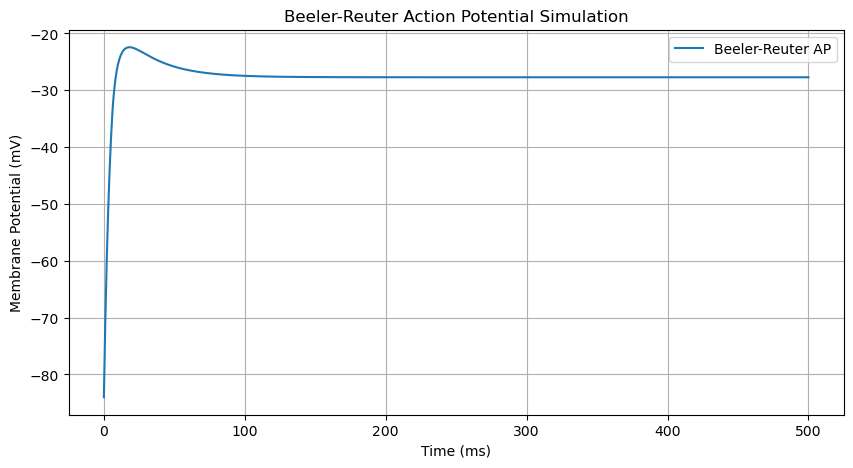

In [34]:
class BeelerReuterModel(pints.ForwardModel):
    """
    Beeler-Reuter 1977 model for cardiac ventricular myocytes.
    Implements dV/dt = - (I_Na + I_Ca + I_K + I_x1 + I_stim)
    """

    def __init__(self):
        super(BeelerReuterModel, self).__init__()

    def n_parameters(self):
        return 1  # Only stimulus current I_stim is treated as a parameter

    def initial_conditions(self):
        """ Initial conditions based on Beeler-Reuter model """
        return [-84.0, 0.01, 0.8, 0.01, 0.1, 1.0]  # [V, m, h, j, d, f]

    def _gating_variables(self, V):
        """ Compute gating variables (steady-state values and time constants) """
        alpha_m = (0.1 * (V + 47)) / (1 - np.exp(-0.1 * (V + 47)))
        beta_m = 4 * np.exp(-0.056 * (V + 72))
        alpha_h = 0.07 * np.exp(-0.05 * (V + 72))
        beta_h = 1 / (1 + np.exp(-0.1 * (V + 42)))
        alpha_j = (0.1 * np.exp(-0.1 * (V + 72))) / (1 + np.exp(-0.1 * (V + 42)))
        beta_j = 0.1 / (1 + np.exp(-0.1 * (V + 42)))

        return alpha_m, beta_m, alpha_h, beta_h, alpha_j, beta_j

    def simulate(self, parameters, times):
        """ Simulate action potential using Beeler-Reuter model """
        I_stim = parameters[0]
        dt = times[1] - times[0]
        num_steps = len(times)
        states = np.zeros((num_steps, 6))  # [V, m, h, j, d, f]
        states[0, :] = self.initial_conditions()

        for i in range(1, num_steps):
            V, m, h, j, d, f = states[i - 1, :]

            # Gating variables
            alpha_m, beta_m, alpha_h, beta_h, alpha_j, beta_j = self._gating_variables(V)
            
            # Ionic currents (simplified)
            I_Na = 4 * (m**3) * h * j * (V - 50)  # Sodium current
            I_Ca = 0.09 * d * f * (V - 120)       # Calcium current
            I_K = 0.282 * (V + 77)                # Potassium current
            I_x1 = 0.001 * (V + 60) / (1 - np.exp(-0.1 * (V + 60)))  # Background current

            # Differential equations
            dVdt = - (I_Na + I_Ca + I_K + I_x1 + I_stim)
            dmdt = alpha_m * (1 - m) - beta_m * m
            dhdt = alpha_h * (1 - h) - beta_h * h
            djdt = alpha_j * (1 - j) - beta_j * j
            dddt = 0.1 * (1 - d) - 0.07 * d  # Simplified calcium activation
            dfdt = 0.02 * (1 - f) - 0.02 * f

            # Euler integration
            states[i, 0] = V + dt * dVdt
            states[i, 1] = m + dt * dmdt
            states[i, 2] = h + dt * dhdt
            states[i, 3] = j + dt * djdt
            states[i, 4] = d + dt * dddt
            states[i, 5] = f + dt * dfdt

        return states[:, 0]  # Return only the voltage trace

# Set up and simulate the Beeler-Reuter model
model = BeelerReuterModel()
times = np.linspace(0, 500, 1000)  # 500ms simulation with 1000 time points
parameters = [-10]  # Stimulus current I_stim

voltage_trace = model.simulate(parameters, times)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(times, voltage_trace, label="Beeler-Reuter AP")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Beeler-Reuter Action Potential Simulation")
plt.legend()
plt.grid()
plt.show()
